# Imports

In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

In [3]:
from pmdarima.arima import ndiffs
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import (LogEndogTransformer,
                                    BoxCoxEndogTransformer)
from pmdarima.model_selection import (train_test_split, 
                                      cross_val_score, 
                                      RollingForecastCV, 
                                      SlidingWindowForecastCV)

# Constants

In [4]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

# Data

In [5]:
data_fb = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'FB.csv', 
    parse_dates=['Date'], 
    index_col=['Date']
)

In [6]:
data_temp = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'Mean_Temp_IMD_2017.csv',
    parse_dates=['YEAR'],
    index_col=['YEAR']
)

In [7]:
data_births = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'daily-total-female-births-CA.csv',
    index_col=['date'],
    parse_dates=['date']
)

# Types of Stationary Behavior in a Time Series

## data_fb

In [8]:
series = data_fb['Close']

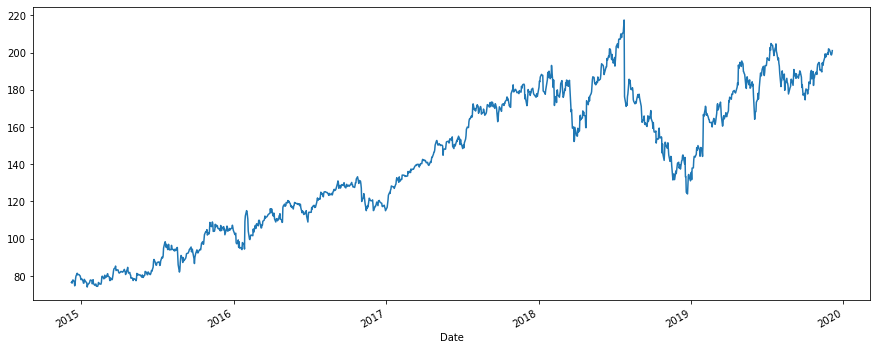

In [9]:
series.plot(figsize=(15, 6))
plt.show()

In [10]:
d = ndiffs(series, alpha=0.05, test='adf')
d

1

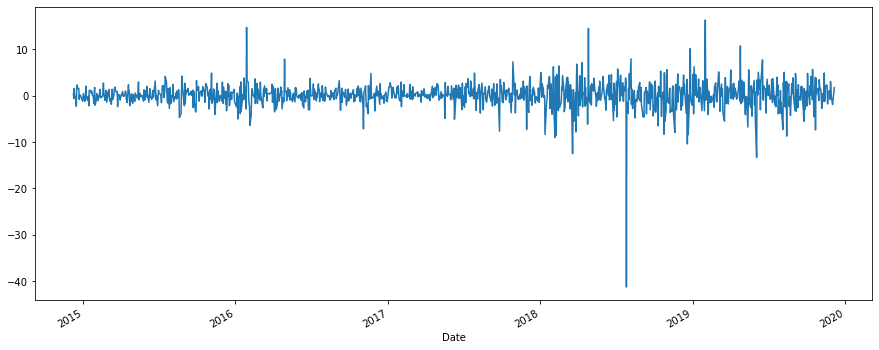

In [11]:
series.diff(d).plot(figsize=(15, 6))
plt.show()

In [12]:
ndiffs(series.diff(d).dropna(), alpha=0.05, test='adf')

0

## data_temp

In [13]:
series = data_temp['ANNUAL_AVG_TEMPRATURE']

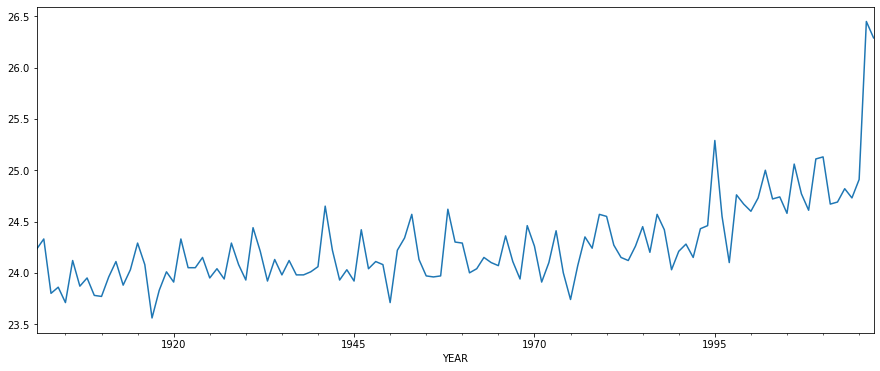

In [14]:
series.plot(figsize=(15, 6))
plt.show()

In [15]:
d = ndiffs(series, alpha=0.05, test='adf')
d

1

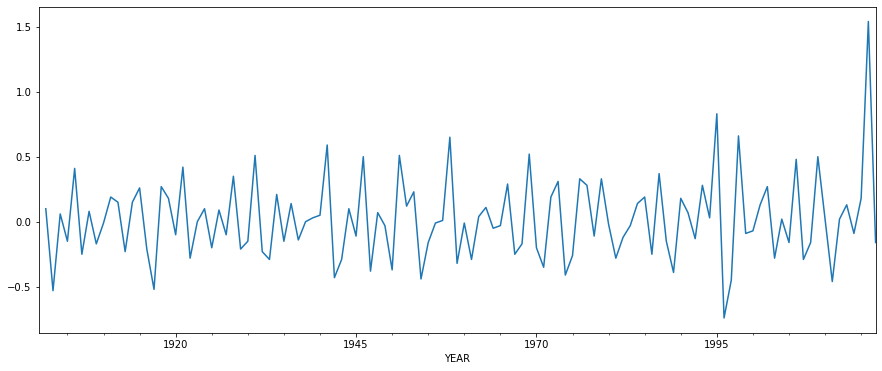

In [16]:
series.diff(d).plot(figsize=(15, 6))
plt.show()

In [17]:
ndiffs(series.diff(d).dropna(), alpha=0.05, test='adf')

0

# AR

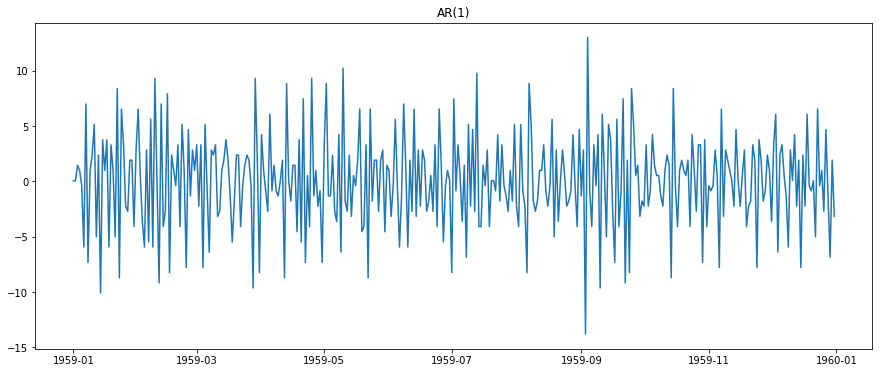

In [18]:
model_ar1 = pm.ARIMA(order=(1, 0, 0))
model_ar1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar1.predict_in_sample())
plt.title('AR(1)')
plt.show()

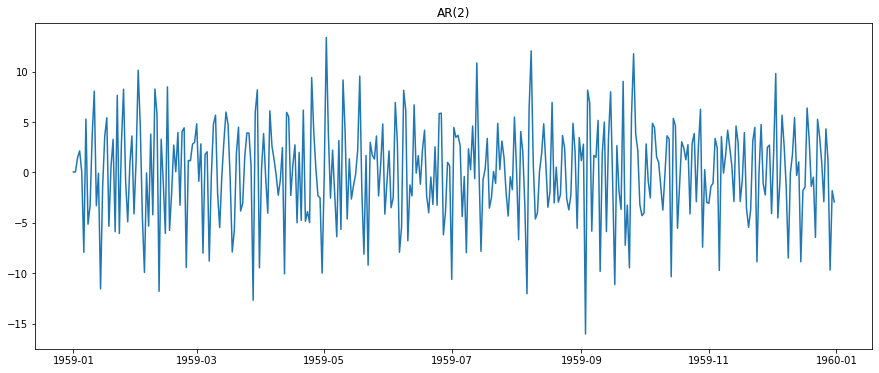

In [19]:
model_ar2 = pm.ARIMA(order=(2, 0, 0))
model_ar2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar2.predict_in_sample())
plt.title('AR(2)')
plt.show()

# MA

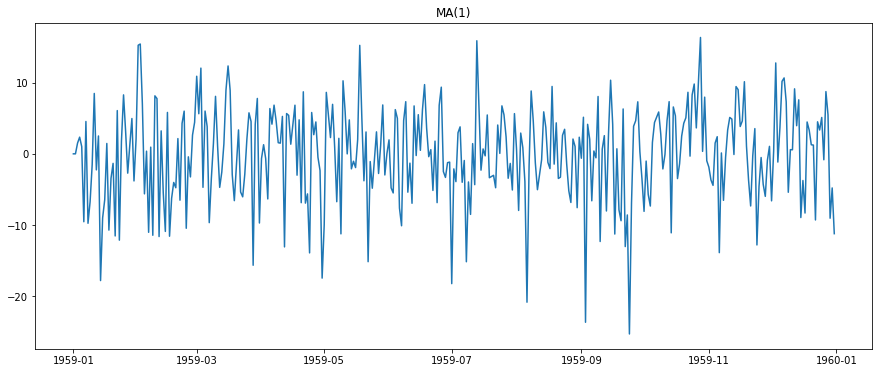

In [20]:
model_ma1 = pm.ARIMA(order=(0, 0, 1))
model_ma1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma1.predict_in_sample())
plt.title('MA(1)')
plt.show()

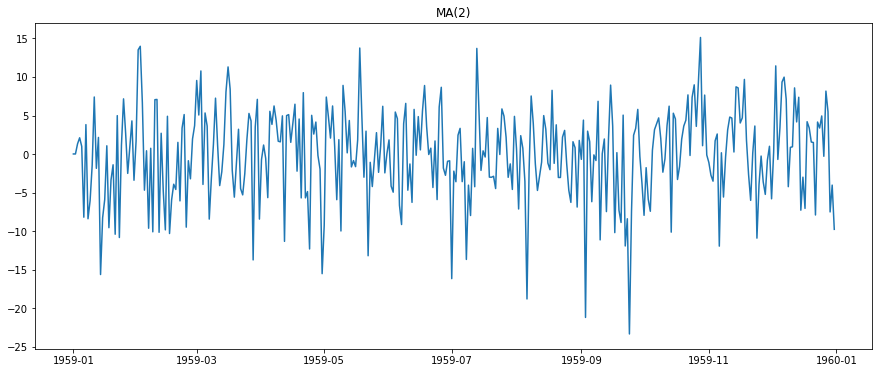

In [21]:
model_ma2 = pm.ARIMA(order=(0, 0, 2))
model_ma2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma2.predict_in_sample())
plt.title('MA(2)')
plt.show()

# ACF and PACF

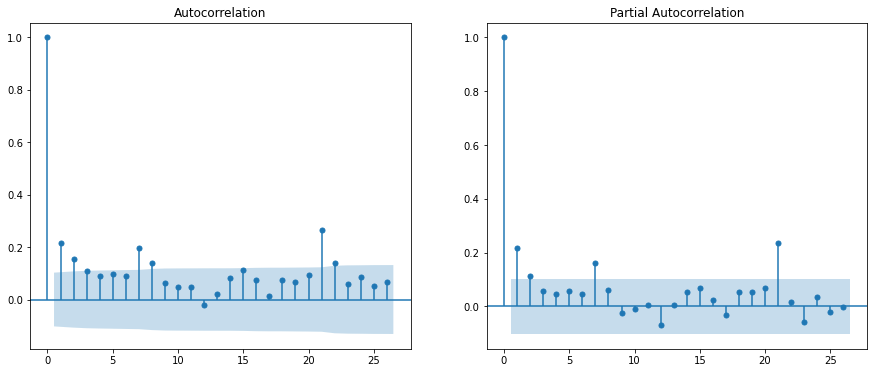

In [22]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.plot_acf(data_births['births'], alpha=0.05, ax=ax1, show=False)
pm.plot_pacf(data_births['births'], alpha=0.05, ax=ax2, show=False)
plt.show()

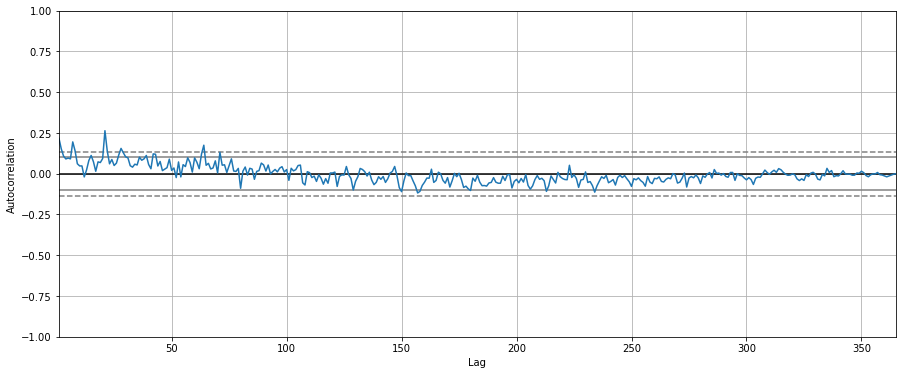

In [23]:
plt.figure(figsize=(15, 6))
pm.autocorr_plot(data_births['births'])

# ARIMA

In [8]:
data_fb.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-12-08  76.180000  77.250000  75.400002  76.519997  76.519997  25733900
2014-12-09  75.199997  76.930000  74.779999  76.839996  76.839996  25358600
2014-12-10  76.650002  77.550003  76.070000  76.180000  76.180000  32210500
2014-12-11  76.519997  78.519997  76.480003  77.730003  77.730003  33462100
2014-12-12  77.160004  78.879997  77.019997  77.830002  77.830002  28091600

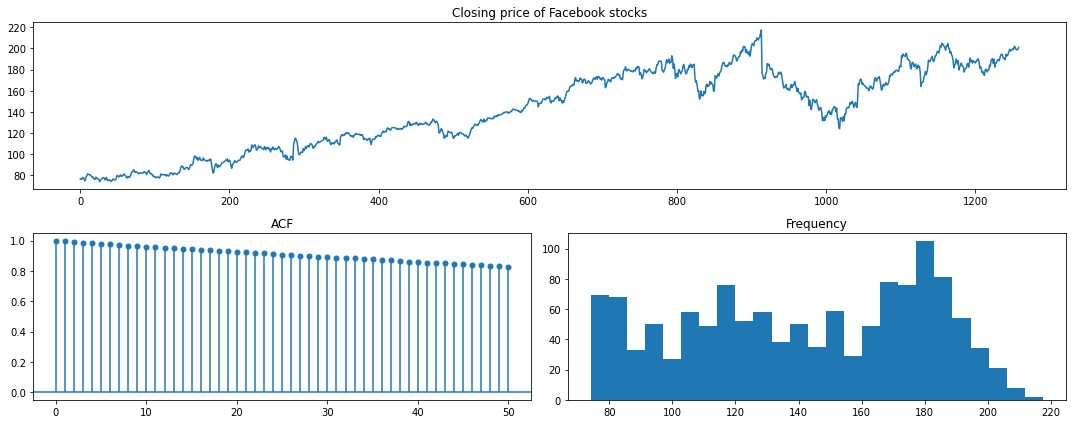

In [9]:
%%capture --no-display
pm.tsdisplay(
    y=data_fb["Close"], 
    figsize=(15, 6),
    title="Closing price of Facebook stocks"
)

In [10]:
pm.arima.ndiffs(data_fb["Close"], alpha=0.05, test='adf')

1

In [44]:
train, test = pm.model_selection.train_test_split(data_fb['Close'], test_size=30)

In [45]:
pipeline = Pipeline([
    ('endog_transformer', LogEndogTransformer()),
    ('model', pm.AutoARIMA(seasonal=False, 
                           information_criterion='aicc', 
                           suppress_warnings=True, 
                           error_action='ignore', 
                           trace=False))
])

In [46]:
cv_scores = cross_val_score(
    estimator=pipeline, 
    y=train, 
    scoring='smape', 
    cv=RollingForecastCV(h=30, step=30)
)

In [47]:
cv_scores.mean(), cv_scores.std()

(4.319811573877433, 2.865823109199374)

In [48]:
pipeline.fit(train)

Pipeline(steps=[('endog_transformer', LogEndogTransformer()),
                ('model',
                 AutoARIMA(error_action='ignore', information_criterion='aicc',
                           seasonal=False))])

In [54]:
pipeline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1229
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3185.630
Date:                Mon, 28 Dec 2020   AIC                          -6369.260
Time:                        22:41:32   BIC                          -6364.147
Sample:                             0   HQIC                         -6367.337
                               - 1229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   3.97e-06     82.292      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             21179.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""